# Kaggle Titanic
## EDA & Preprocessing
이전에 공부 할 때 작성한 자료입니다.  
### 데이터셋 전처리 및 EDA
캐글의 경우, 훈련용과 테스트용 데이터 셋이 따로 제공되므로, 해당 파일에서는 훈련용 데이터 셋의 EDA와 전처리를 진행함
### 사용 라이브러리

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

### Data Load

In [ ]:
train = pd.read_csv("data/train.csv", encoding="utf-8")
train.shape

### 기본 정보

In [ ]:
display(train.info())

- Survived: 생존 여부 => 0 = No, 1 = Yes
- pclass: 티켓 등급 => 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex: 성별
- Age: 나이
- Sibsp: 함께 탑승한 형제자매, 배우자의 수
- Parch: 함께 탑승한 부모, 자식의 수
- Ticket: 티켓 번호
- Fare: 운임
- Cabin: 객실 번호
- Embarked: 탑승 항구 => C = Cherbourg, Q = Queenstown, S = Southampton

### 결측치 확인

In [ ]:
print(train.isnull().sum())
sns.heatmap(train.isnull());

In [ ]:
temp = train.isnull().mean()
temp[temp!=0]

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

`Age`에서 20%, `Cabin`에서 77%, `Embarked`에서 0.002% 정도의 결측치가 존재함  
`Cabin`과 `Embarked`는 문자열 형식의 데이터로, 모델과 직접적인 영향을 미비할 것이라고 생각됨

### 생존자

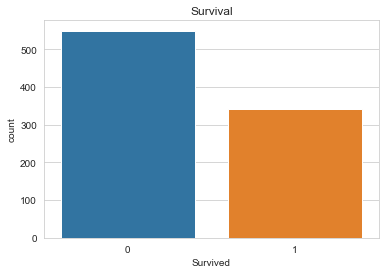

In [ ]:
_ = sns.histplot(data=train, x="Survived").set_title("Survival")

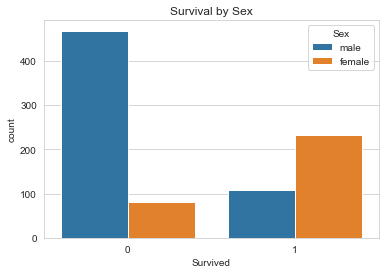

In [ ]:
_ = sns.histplot(data=train, x="Survived", hue="Sex").set_title("Survival by Sex")

생존 여부와 성별의 연관성이 있을것으로 생각됨

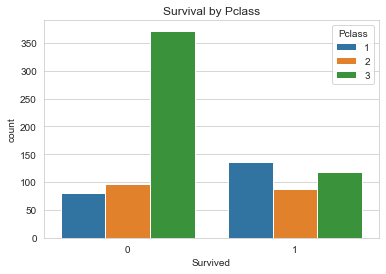

In [ ]:
_ = sns.histplot(data=train, x="Survived", hue="Pclass").set_title("Survival by Pclass")

티켓 등급과 생존 여부도 어느정도 연광성이 있을것이라 생각됨

### Data Cleaning
#### Age

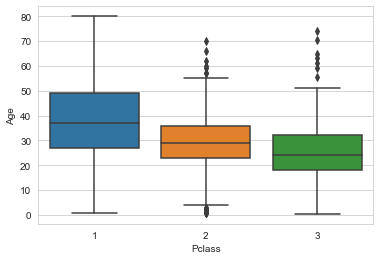

In [ ]:
_ = sns.boxenplot(data=train, x="Pclass", y="Age")

In [ ]:
train.groupby("Pclass")["Age"].describe()

결측치가 있는 `Age`를 `Pclass`의 평균 나이값을 이용해 대채하는 방식이 굉장히 인상 깊었음  
일반적으로 평균이나 중앙값을 이용하는 방식이 아닌, 다른 변수를 이용해 좀 더 균등하게 결측치를 대체할 수 있는 방식이라고 생각됨

In [ ]:
def age_pclass(cols):
    # TODO
    cols = cols.groupby([0][1])[[0][0]]
    return cols

In [ ]:
train["Age"] = train[["Age", "Pclass"]].apply(age_pclass, axis=1)

#### Embarked
탑승지의 경우, 결측치의 양이 적고 크게 생존 여부와 큰 상관이 없을것 같으므로 임의로 채워줌

In [ ]:
train["Embarked"] = train["Embarked"].fillna('S')

#### Cabin
`Cabin`의 경우 열을 버려줌

In [ ]:
train.drop(columns='Cabin', axis=1, inplace=True)

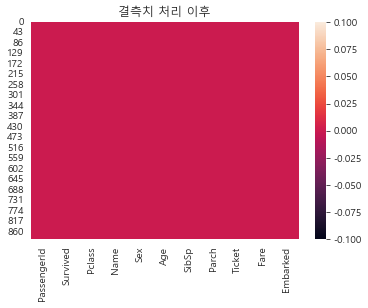

In [ ]:
_ = sns.heatmap(train.isnull()).set_title("결측치 처리 이후")

In [ ]:
train.dropna(inplace=True)

#### 범주형 데이터 변환

범주형 데이터는 학습에서 바로 사용이 불가능하기 때문에 수치형으로 변환이 필요합니다.  
예를 들어, `Sex`의 경우 `Male=0`, `Female=1`과 같이 변환을 합니다.

In [ ]:
train["Sex"] = train["Sex"].replace('Male', 0).replace("Female", 1)
train["Embarked"] = train["Embarked"].replace('C', 0).replace("Q", 1).replace("S", 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


현재 범주형 데이터는, `Name, Sex, Ticket, Embarked`가 있음

#### pd.get_dummies
학습 이전에 모든 데이터를 수치로 변환해주는 전처리 작업이 필요함  
1. 수치형 데이터로 변환
2. 수치화된 데이터를 가변수화

##### Note!!! - 가변수화
수치형 데이터로만 변환하면, **서로 간의 관계성**이 생기게 되어버림
- 월, 화, 수 ... -> 1, 2, 3 ...
- 1+2=3 / 월+화=수라는 관계성이 성립해버림

`pandas`의 `get_dummies` 함수는 원핫인코딩을 이용하는 방식  
`get_dummies(data=, prefix=, prefix_sep=, dummy_na=, columns=, drop_first=, dtype=)` 형식으로 존재함
- data: one-hot encoding을 적용할 데이터
- prefix: 생성할 더미 데이터(가변수화된 데이터)의 컬럼 prefix
- prefix_sep: `default='_'`
- dummpy_na: `NaN`도 포함시킬지, `default=False`
- columns: 대상 컬럼
- drop_first: k개의 범주를 k-1개로 가변수화할 경우 사용
- dtype: 새로운 columns의 데이터 타입

In [ ]:
sex = pd.get_dummies(data=train["Sex"], drop_first=True)
embark = pd.get_dummies(data=train["Embarked"], drop_first=True)

In [ ]:
# 가변수화된 컬럼으로 대체
train.drop(columns=["Sex", "Embarked", "Name", "Ticket"], axis=1, inplace=True)
train = pd.concat([train, sex, embark], axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1
